In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_path = "/home/clairegayral/Documents/openclassroom/data/"

## my .py : 
import read_csv
import preprocess
import list_from_data_field 
import missing_values_treatment

My preprocess consisted in : 
* Read the data : I only kept data with the "nutrition score" for this analyse,
* Drop the columns with too many missing values
* Select the variables that will interest me : the nutrition variable, with name of the product, its code reference, country of sell, and name of the person that inter it in the open food fact base.
* Merge the two columns that are about the palm oil ingredients.
* Remove outliers (from the semantic of columns, and compared to the other values)

Mon prétraitement consistait en : 
* Lecture des données : Je n'ai gardé que les données avec le "score nutritionnel" pour cette analyse,
* Suppression des colonnes avec trop de valeurs manquantes
* Sélection des variables d'intérêt : la variable nutritionnelle, avec le nom du produit, sa référence de code, le pays de vente, et le nom de la personne qui l'a introduit dans la base de données 'open food facts'.
* Fusion des deux colonnes qui concernent les ingrédients de l'huile de palme.
* Fusion des doublons (par nom de produit)
* Suppression les valeurs aberrantes (de la sémantique des colonnes, et par rapport aux autres valeurs).


In [2]:
##
## read data : 
##

# read_csv.save_csv()
df_original = pd.read_csv(data_path+"projet2/df_original.csv", 
                          low_memory=False, index_col=0)

##
## drop empty columns
##

nan_repartition = df_original.isna().sum(axis=0)
# nan_threshold = nan_repartition.mean()
nan_threshold = nan_repartition.quantile(0.75)
# df = preprocess.preprocess_drop_col_nan(df_original, nan_threshold)
df = df_original.copy()
##
## select variables 
##

list_of_nutri_facts = list_from_data_field.list_of_nutri_facts
interest_var = pd.Index(["code","product_name","creator","countries",
                         "additives_n","ingredients_from_palm_oil"])
interest_var = interest_var.append(df.columns.intersection(list_of_nutri_facts))
df = preprocess.select_columns(df, interest_var)

##
## set dtype : 
##

df = preprocess.set_dtypes(df)

##
## merge "from palm oil" 
##

df = preprocess.merge_palm_oil_cols(df)

In [3]:
float_var = list_from_data_field.list_of_nutri_facts
float_var += ["additives_n", "ingredients_from_palm_oil_n","ingredients_from_palm_oil_n"]
float_var = df.columns.intersection(float_var).values

import missing_values_treatment
##
## from the hyp that the variable has been entered in mg instead of g -> rescale 
##
df = missing_values_treatment.rescale_outliers100g_val(df)

##
## drop outliers values and drop product/variables with too many NaNs
##
df = missing_values_treatment.drop_outliers(df)
df.shape

(249360, 50)

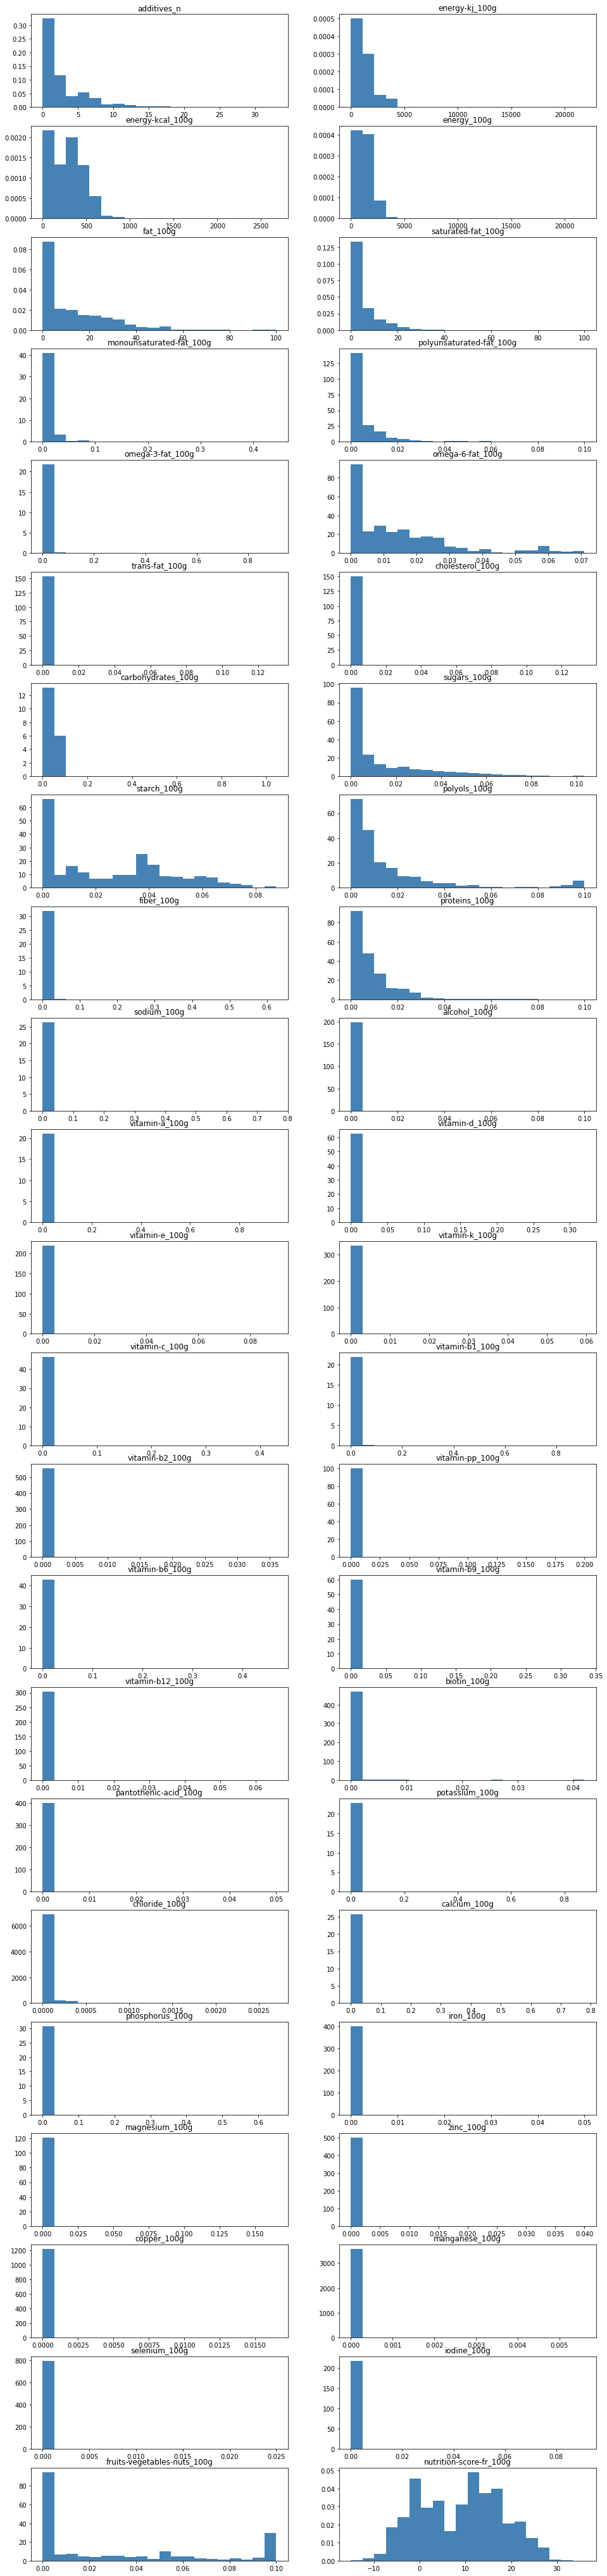

In [5]:
nb_line_plot = int(np.floor(len(float_var)/2)+1)
fig = plt.figure(figsize=(16, 100))

fig_count = 1
for var in df.columns.intersection(float_var) :#data.columns.intersection(list_of_nutri_facts):
    ax = fig.add_subplot(nb_line_plot,2, fig_count)
    nb_bins = min(20, len(np.unique(df[var].dropna().values)))
    ax.hist(df[var], bins = nb_bins, color='steelblue', density=True, edgecolor='none')
    ax.set_title(var)
    fig_count += 1
plt.show()

In [ ]:
data = df.copy()
colname = "additives_n"
possible_vals = possible_val_dict[colname]


help_to_set_outliers_vals(data, colname, possible_vals)

In [ ]:
import list_from_data_field
float_var = list_from_data_field.list_of_characteristics 

floa